In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, _ in os.walk("/kaggle/input/thesis-data-splitted/Morse"):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis-data-splitted/Morse
/kaggle/input/thesis-data-splitted/Morse/val
/kaggle/input/thesis-data-splitted/Morse/val/LVLA
/kaggle/input/thesis-data-splitted/Morse/val/HVHA
/kaggle/input/thesis-data-splitted/Morse/val/HVLA
/kaggle/input/thesis-data-splitted/Morse/val/LVHA
/kaggle/input/thesis-data-splitted/Morse/train
/kaggle/input/thesis-data-splitted/Morse/train/LVLA
/kaggle/input/thesis-data-splitted/Morse/train/HVHA
/kaggle/input/thesis-data-splitted/Morse/train/HVLA
/kaggle/input/thesis-data-splitted/Morse/train/LVHA


In [2]:
!pip list | grep "torch\|cuda\|fast\|timm"

cupy-cuda113                           10.6.0
fastai                                 2.7.12
fastapi                                0.89.1
fastavro                               1.7.0
fastcore                               1.5.29
fastdownload                           0.0.7
fasteners                              0.18
fastjsonschema                         2.16.2
fastprogress                           1.0.3
fastrlock                              0.8
fasttext                               0.9.2
jaxlib                                 0.3.25+cuda11.cudnn805
pycuda                                 2022.1
pyfasttext                             0.4.6
pytorch-ignite                         0.4.11
pytorch-lightning                      1.9.4
timm                                   0.6.13
torch                                  1.13.0
torchaudio                             0.13.0
torchinfo                              1.7.2
torchmetrics                           0.11.4
torchtext                     

In [3]:
import gc
import pandas as pd
import albumentations as A
from fastai.vision.all import *
from fastai.test_utils import *

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_val = 111
seed_everything(seed_val)

In [5]:
arch = 'convnext_small_384_in22ft1k'
loss_func = CrossEntropyLossFlat()
metrics = [accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted'), BalancedAccuracy()]

In [6]:
# Source: https://forums.fast.ai/t/albumentation-transformations-for-train-and-test-dataset/82642
class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): 
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.OneOf([
                    A.CLAHE(),
                    A.HueSaturationValue(0.2, 0.2, 0.2, p=0.5)
                ],p=0.4),
        A.OneOf([
                    A.MotionBlur(p=.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
                ], p=0.2),
    ])

def get_valid_aug():
    return A.Compose([], p=1.0)

In [7]:
data_path = "/kaggle/input/thesis-data-splitted/Morse"
trn_path = f"{data_path}/train"
tst_path = f"{data_path}/val"

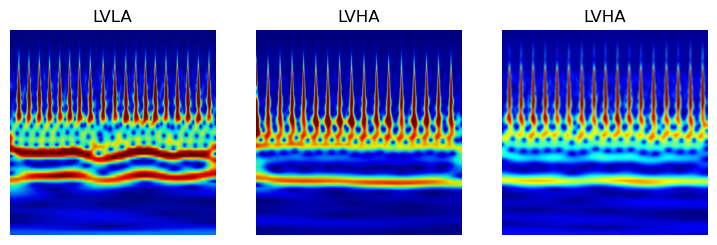

In [8]:
dls = ImageDataLoaders.from_folder(
    trn_path, valid_pct=0.10, 
    item_tfms=[Resize(384), AlbumentationsTransform(get_train_aug(), get_valid_aug())], 
    batch_tfms=Normalize.from_stats(*imagenet_stats), 
    bs=64, seed=seed_val)

dls.show_batch(max_n=3)

In [9]:
learn = vision_learner(dls, arch, metrics=metrics, path='.', cbs=CSVLogger()).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_1k_384.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_1k_384.pth


SuggestedLRs(valley=0.009120108559727669)

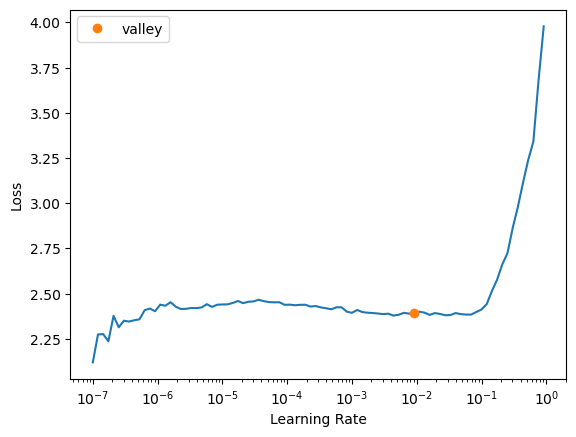

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(
    100,
    0.0075, 
    cbs=[
        EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=15),
        SaveModelCallback(monitor='accuracy', min_delta=0.01)
    ]
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,2.019449,1.380274,0.387612,0.382822,0.387612,0.380484,0.370727,05:04
1,1.771385,1.339797,0.399600,0.397375,0.399600,0.391709,0.379869,05:01
2,1.573627,1.307927,0.396603,0.397876,0.396603,0.382169,0.375639,05:01
3,1.439568,1.252205,0.435564,0.439299,0.435564,0.423322,0.409709,05:01
4,1.329790,1.259514,0.407592,0.409450,0.407592,0.405830,0.399177,05:01
5,1.282076,1.212069,0.454545,0.454291,0.454545,0.443302,0.429347,05:01
6,1.239288,1.201422,0.462537,0.461955,0.462537,0.459505,0.447975,05:01
7,1.200394,1.172929,0.489510,0.493941,0.489510,0.480129,0.474579,05:01
8,1.184514,1.226218,0.445554,0.448578,0.445554,0.438375,0.444627,05:02
9,1.172436,1.145693,0.494505,0.506966,0.494505,0.480389,0.465818,05:01


Better model found at epoch 0 with accuracy value: 0.38761240243911743.
Better model found at epoch 1 with accuracy value: 0.39960038661956787.
Better model found at epoch 3 with accuracy value: 0.43556442856788635.
Better model found at epoch 5 with accuracy value: 0.4545454680919647.
Better model found at epoch 7 with accuracy value: 0.4895104765892029.
Better model found at epoch 10 with accuracy value: 0.5254745483398438.
Better model found at epoch 12 with accuracy value: 0.5454545617103577.
Better model found at epoch 13 with accuracy value: 0.5764235854148865.
Better model found at epoch 14 with accuracy value: 0.6103895902633667.
Better model found at epoch 18 with accuracy value: 0.6593406796455383.
Better model found at epoch 24 with accuracy value: 0.710289716720581.
Better model found at epoch 27 with accuracy value: 0.739260733127594.
Better model found at epoch 31 with accuracy value: 0.8221778273582458.
Better model found at epoch 38 with accuracy value: 0.85514485836029

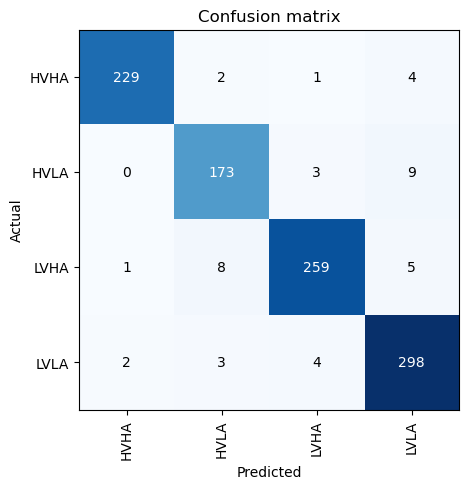

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    history = pd.read_csv('/kaggle/working/history.csv').drop(columns=['epoch', 'time'])
    metrics = history.values
    names = history.columns
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

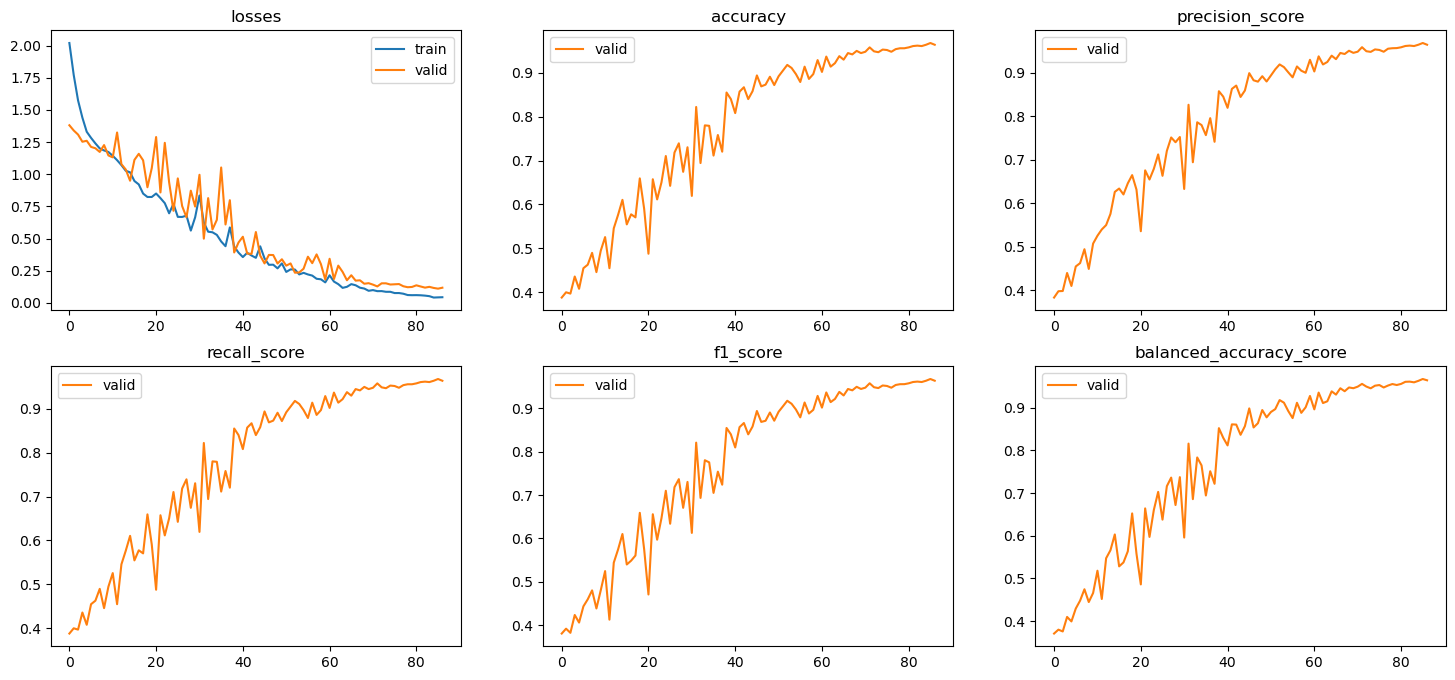

In [14]:
learn.recorder.plot_metrics()

In [15]:
del learn; torch.cuda.empty_cache(); gc.collect()

35857

In [16]:
learn = vision_learner(dls, arch, metrics=metrics, path='.').load('/kaggle/working/models/model')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [17]:
dls_tmp = ImageDataLoaders.from_folder("/kaggle/input/thesis-data-splitted/Morse", valid="val", item_tfms=Resize(224), seed=seed_val)
_, targs = learn.get_preds(dl=dls_tmp.valid)

In [18]:
test_dl = dls.test_dl(get_image_files(tst_path), bs=32, with_label=True)
preds, _ = learn.get_preds(dl=test_dl)

In [19]:
acc = accuracy(preds, targs)

In [20]:
tta_preds,_ = learn.tta(dl=test_dl)

In [21]:
tta = accuracy(tta_preds, targs)

In [22]:
tta_preds = tta_preds.argmax(dim=1)

In [23]:
tta > acc

TensorBase(True)

In [24]:
preds = tta_preds if tta > acc else preds

In [25]:
pd.DataFrame(preds, columns=['preds']).to_csv('predictions.csv')

In [26]:
from sklearn.metrics import classification_report
df = pd.DataFrame(classification_report(targs, preds, target_names=dls.vocab, output_dict=True)).transpose()
df

,precision,recall,f1-score,support
HVHA,0.978448,0.919028,0.947808,247.000000
HVLA,0.943925,0.952830,0.948357,212.000000
LVHA,0.975439,0.961938,0.968641,289.000000
LVLA,0.927083,0.970027,0.948069,367.000000
accuracy,0.953363,0.953363,0.953363,0.953363
macro avg,0.956224,0.950956,0.953219,1115.000000
weighted avg,0.954197,0.953363,0.953398,1115.000000


In [27]:
learn.save('my_model')

Path('models/my_model.pth')